In [ ]:
"""
TODOs:
Build a graph where nodes are master tags, and edges are relational strength between two tags 
(for example, np-array and np-matrix as two individual tags that are highly coorelated with one another). 
As a measure of strength between tags, see cosine similiarity. 
Since there are a constant number of tags (roughly 6000), represent the graph as an adjacency matrix.

Notes:
https://tinyurl.com/y9hcxglo
"""

In [1]:
import pandas as pd
from collections import Counter, defaultdict
import json
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
PATH = '/Users/John/PycharmProjects/160-Stackoverflow/source/sandbox/300000_rows/'
QUESTION = 1
ANSWER = 2
UP = 2
DOWN = 3
path = lambda x: PATH + x

In [2]:
posts = pd.read_csv(path('Posts.csv'))
votes = pd.read_csv(path('Votes.csv'))

/Users/John/Dropbox/ECS171/HW3/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
posts['ParentID'] = posts['ParentID'].fillna(0).astype(int)
posts['AcceptedAnswerId'] = posts['AcceptedAnswerId'].fillna(0).astype(int)

### What is the ratio of questions left answered?

In [4]:
questions = posts[posts['PostTypeId'] == QUESTION]
unanswered = questions[questions['AcceptedAnswerId'] == 0]
#len(questions[questions['AnswerCount'] == 0]) / len(questions)

### What is the ratio of questions without an accepted answer?

In [ ]:
len(unanswered) / len(questions)

In [ ]:
unanswered.rename(columns = {'Id':'PostId'}, inplace = True)
upvotes = votes[votes['VoteTypeId'] == UP]

In [ ]:
no_ans_q = questions[questions['AnswerCount'] == 0]
no_ans_q.rename(columns = {'Id':'PostId'}, inplace = True)
uv_no_ans = upvotes.join(no_ans_q.set_index('PostId'), on='PostId', how='inner', lsuffix='_x')

In [ ]:
# List the 15 most upvoted questions that are unanswered.
top_uv_no_ans = Counter(uv_no_ans['PostId']).most_common(15)

### List the 15 most upvoted questions that are unanswered.

In [ ]:
unanswered.sort_values(by='Score',ascending=False)[:15]

In [5]:
posts['CreationDate'] = pd.to_datetime(posts.CreationDate)
#posts.sort_values(by='CreationDate')[:10]

### What is the mean and median response for a question for each of the 20 most popular tags?
The mean and median response is the difference between when the question is asked and when the first answer is. 

In [6]:
tags = pd.read_csv('/Users/John/PycharmProjects/160-Stackoverflow/source/sandbox/tags/tag_distribution.csv')

In [7]:
top_tags = tags.sort_values(by='frequency', ascending=False)[:20]

#### Getting the time between the question is asked and the accepted answer 

In [8]:
answers = posts[posts['PostTypeId'] == ANSWER] 
def time_diff(question_row):
    answer_row = answers.loc[answers['Id'] == question_row['AcceptedAnswerId']]
    return answer_row.get_value(answer_row.index.values[0], 'CreationDate') - question_row.get_value(4)

In [9]:
questions['CreationDate'] = pd.to_datetime(questions['CreationDate'])

/Users/John/Dropbox/ECS171/HW3/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
answered_questions = questions[questions['AcceptedAnswerId'] != 0]
answered_questions['AcceptedAnswerTime'] = answered_questions.apply(time_diff, axis=1)

/Users/John/Dropbox/ECS171/HW3/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/Users/John/Dropbox/ECS171/HW3/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
tag_dict = json.load(open('/Users/John/PycharmProjects/160-Stackoverflow/source/sandbox/tag_network_load.json'))

In [36]:
# tag with accepted answer time in hours
post_by_tags = pd.DataFrame(columns=list(top_tags['tag']))
for tag in top_tags['tag']:
    rows = answered_questions.loc[posts['Id'].isin(tag_dict[tag])]
    # convert to hours
    post_by_tags[tag] = rows['AcceptedAnswerTime'].apply(lambda x: x.seconds / 3600)

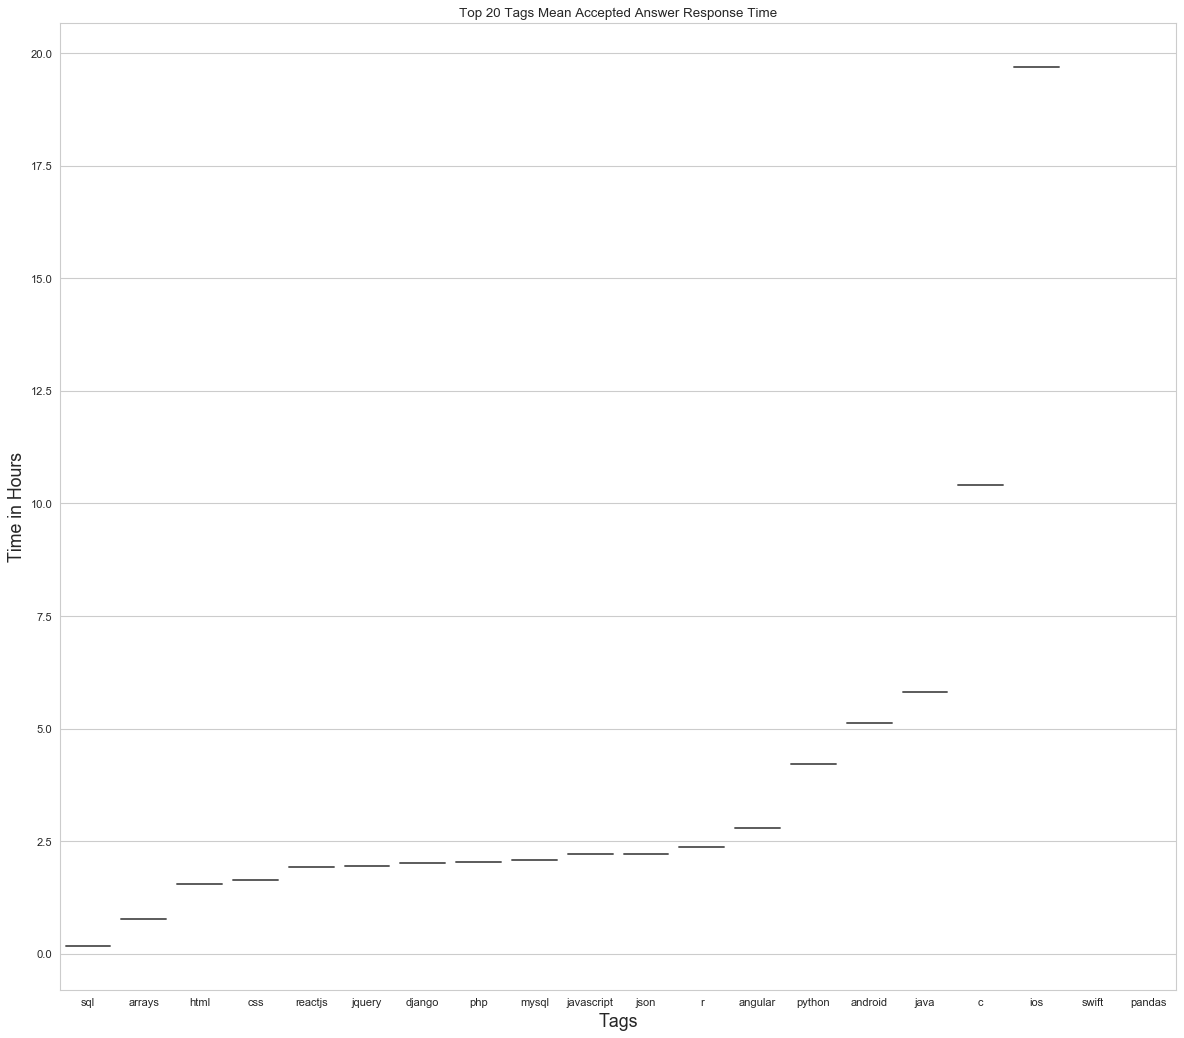

In [90]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
mean_responses = post_by_tags.mean().sort_values()
sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel="Tags", ylabel="Time in Hours",fontsize=16)
ax = sns.boxplot(x=mean_responses.axes[0].values, y=list(mean_responses),palette="Set3")
ax.set_title('Top 20 Tags Mean Accepted Answer Response Time')
plt.show()

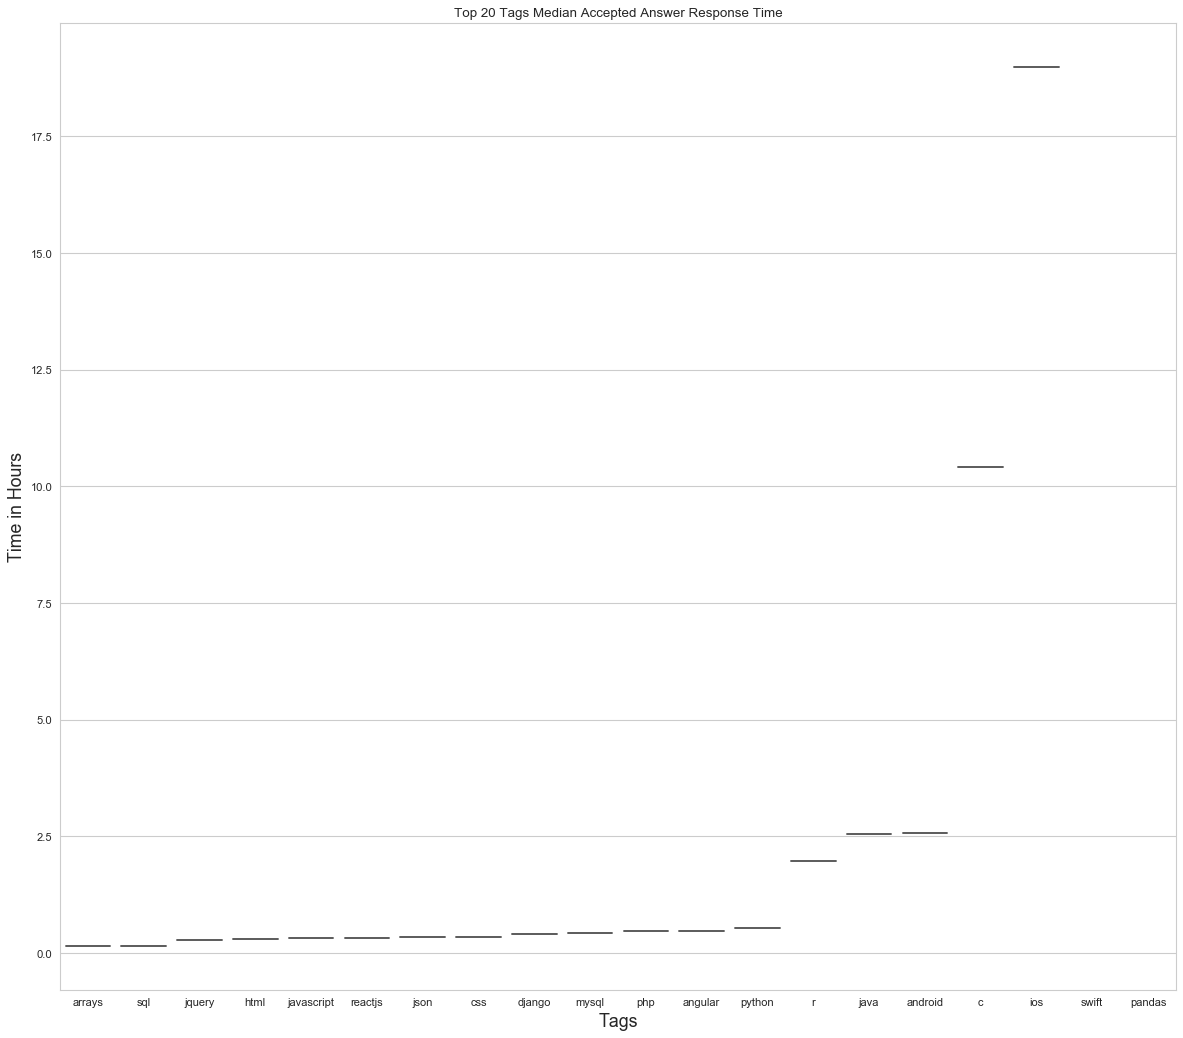

In [93]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
median_responses = post_by_tags.median().sort_values()
sns.set(context='notebook', style='whitegrid')
sns.utils.axlabel(xlabel="Tags", ylabel="Time in Hours",fontsize=16)
ax = sns.boxplot(x=median_responses.axes[0].values, y=list(median_responses),palette="Set3")
ax.set_title('Top 20 Tags Median Accepted Answer Response Time')
plt.show()